<a href="https://colab.research.google.com/github/omdgit/AppliedTimeSeriesAnalysisWithPython/blob/main/my work/HOTSAP_SARIMAX.ipynb " target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Chapter 12 - Exercise  
As an exercise, we will prepare some data for use in deep learning exercises in chap- ters 12 through 18. This data will be used to develop a deep learning model to fore- cast the air quality in Beijing at the Aotizhongxin station.
Specifically, for univariate modeling, we will ultimately predict the concentration of nitrogen dioxide (NO2). For the multivariate problem, we will predict the concentration of nitrogen dioxide and temperature.

In [15]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt, dates as mdates, ticker as mticker

import warnings
warnings.filterwarnings('ignore')

import sys

sys.path.append('../../My-Code/')
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

import timetools as tt

%matplotlib inline

In [4]:
# plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False
plt.style.use('seaborn')

In [5]:
tf.random.set_seed(51)
np.random.seed(51)

## Read the data

In [12]:
df = pd.read_csv('../data/beijing_air_quality.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18914 entries, 2015-01-02 22:00:00 to 2017-02-28 23:00:00
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       18914 non-null  int64  
 1   PM2.5    18914 non-null  float64
 2   PM10     18914 non-null  float64
 3   SO2      18914 non-null  float64
 4   NO2      18914 non-null  float64
 5   CO       18914 non-null  float64
 6   O3       18914 non-null  float64
 7   TEMP     18914 non-null  float64
 8   PRES     18914 non-null  float64
 9   DEWP     18914 non-null  float64
 10  RAIN     18914 non-null  float64
 11  wd       18914 non-null  object 
 12  WSPM     18914 non-null  float64
 13  station  18914 non-null  object 
dtypes: float64(11), int64(1), object(2)
memory usage: 2.2+ MB


,No,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
datetime,,,,,,,,,,,,,,
2015-01-02 22:00:00,16151,118.0,147.0,58.0,100.0,2000.0,2.0,-5.0,1021.0,-17.2,0.0,SW,0.7,Aotizhongxin
2015-01-02 23:00:00,16152,137.0,179.0,63.0,101.0,2100.0,2.0,-6.0,1018.0,-14.3,0.0,NNW,0.7,Aotizhongxin
2015-01-03 00:00:00,16153,141.0,215.0,59.0,100.0,2300.0,2.0,-7.0,1016.0,-15.9,0.0,SSE,0.4,Aotizhongxin
2015-01-03 01:00:00,16154,136.0,158.0,65.0,106.0,3000.0,2.0,-7.0,1016.0,-12.7,0.0,ESE,0.4,Aotizhongxin
2015-01-03 02:00:00,16155,132.0,163.0,56.0,107.0,3000.0,2.0,-6.0,1014.0,-16.9,0.0,NE,1.1,Aotizhongxin


## Plot the target

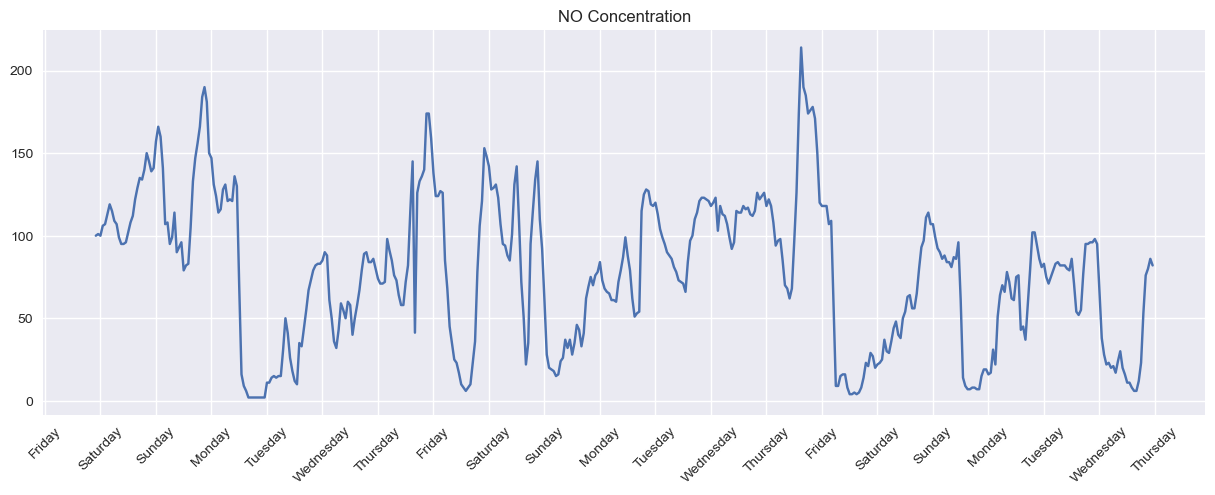

In [45]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df.loc['2015-01-01':'2015-01-21']['NO2'])
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%A'))
# ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
plt.xticks(rotation=45)
ax.set_title('NO Concentration')
ax
plt.show()

## Remove unnecessary columns

In [47]:
df.head(30)

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,WSPM
datetime,,,,,,,,,,
2015-01-02 22:00:00,118.0,147.0,58.0,100.0,2000.0,2.0,-5.0,1021.0,-17.2,0.7
2015-01-02 23:00:00,137.0,179.0,63.0,101.0,2100.0,2.0,-6.0,1018.0,-14.3,0.7
2015-01-03 00:00:00,141.0,215.0,59.0,100.0,2300.0,2.0,-7.0,1016.0,-15.9,0.4
2015-01-03 01:00:00,136.0,158.0,65.0,106.0,3000.0,2.0,-7.0,1016.0,-12.7,0.4
2015-01-03 02:00:00,132.0,163.0,56.0,107.0,3000.0,2.0,-6.0,1014.0,-16.9,1.1
2015-01-03 03:00:00,148.0,181.0,66.0,113.0,3800.0,2.0,-6.0,1019.0,-16.9,1.0
2015-01-03 04:00:00,178.0,222.0,87.0,119.0,4800.0,2.0,-5.0,1013.0,-16.8,1.2
2015-01-03 05:00:00,177.0,209.0,76.0,115.0,4500.0,2.0,-5.0,1014.0,-16.8,1.6
2015-01-03 06:00:00,180.0,218.0,79.0,109.0,4500.0,2.0,-4.0,1012.0,-16.6,1.6


In [33]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
No,18914.0,25607.500000,5460.145831,16151.0,20879.250,25607.5,30335.75,35064.0
PM2.5,18914.0,79.407220,83.816615,3.0,19.000,54.0,107.00,898.0
PM10,18914.0,103.687485,95.725767,3.0,33.225,78.0,143.00,984.0
SO2,18914.0,13.201725,17.090182,2.0,2.000,7.0,16.00,341.0
NO2,18914.0,55.560272,37.834273,2.0,26.000,47.0,77.00,290.0
CO,18914.0,1324.737573,1351.213878,100.0,500.000,900.0,1600.00,10000.0
O3,18914.0,61.602319,58.980450,2.0,13.000,49.0,87.00,423.0
TEMP,18914.0,12.741331,11.751367,-16.8,2.000,13.0,23.10,38.8
PRES,18914.0,1013.480721,10.470266,987.5,1004.900,1013.2,1022.10,1042.0
DEWP,18914.0,1.399363,13.830859,-35.3,-10.100,1.3,14.00,27.3


In [ ]:
cols_to_drop = ['No', 'RAIN', 'wd', 'station']
df = df.drop(cols_to_drop, axis=1)

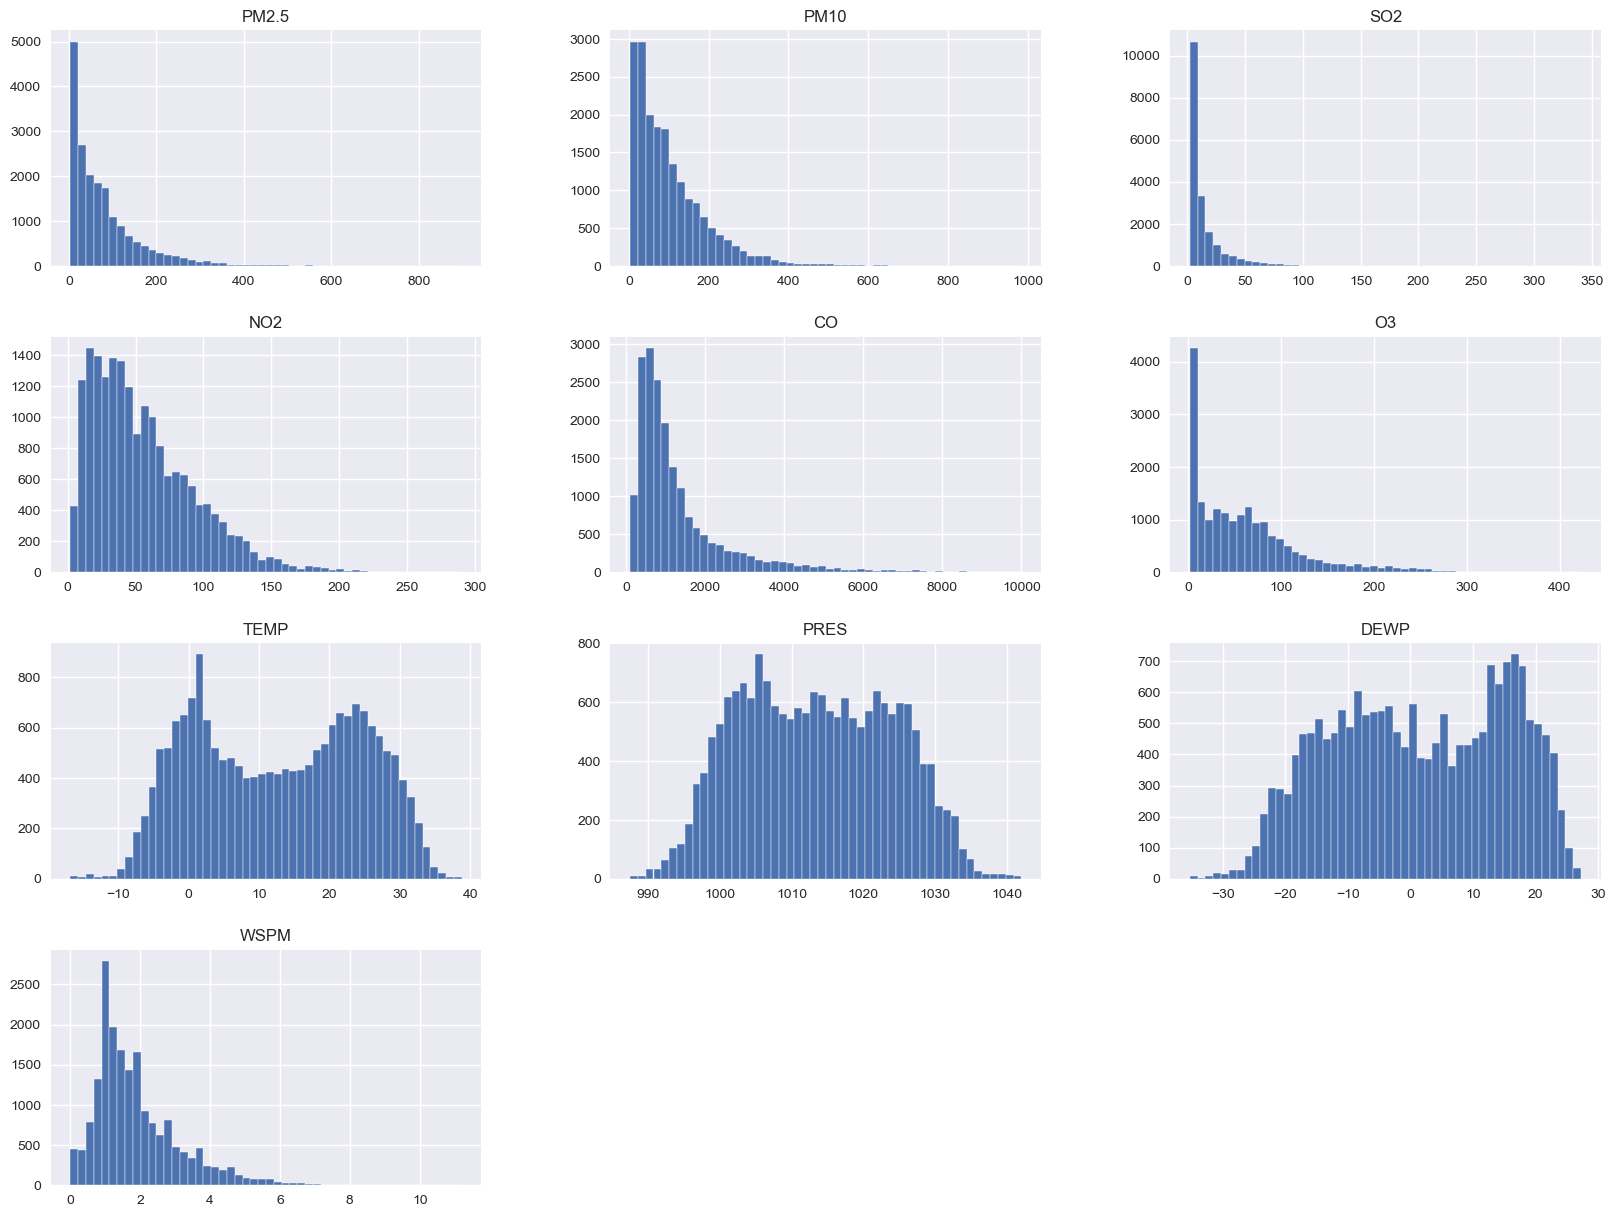

In [42]:
df.hist(bins=50, ec='white', figsize=(20,15))
plt.show()

## Identify whether there is daily seasonality and encode the time accordingly

In [51]:
df_daily = df[2:][::24]
df_daily['Day'] = df_daily.index
df_daily.info()
df_daily.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 788 entries, 2015-01-03 to 2017-02-28
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   PM2.5   788 non-null    float64       
 1   PM10    788 non-null    float64       
 2   SO2     788 non-null    float64       
 3   NO2     788 non-null    float64       
 4   CO      788 non-null    float64       
 5   O3      788 non-null    float64       
 6   TEMP    788 non-null    float64       
 7   PRES    788 non-null    float64       
 8   DEWP    788 non-null    float64       
 9   WSPM    788 non-null    float64       
 10  Day     788 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(10)
memory usage: 73.9 KB


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,WSPM,Day
datetime,,,,,,,,,,,
2015-01-03,141.0,215.0,59.0,100.0,2300.0,2.0,-7.0,1016.0,-15.9,0.4,2015-01-03
2015-01-04,238.0,278.0,103.0,157.0,5600.0,2.0,-4.0,1011.0,-13.7,1.5,2015-01-04
2015-01-05,214.0,248.0,112.0,147.0,5300.0,2.0,3.0,1009.0,-10.3,1.6,2015-01-05
2015-01-06,13.0,29.0,16.0,11.0,500.0,42.0,-1.0,1026.0,-25.2,2.9,2015-01-06
2015-01-07,100.0,161.0,58.0,85.0,2200.0,2.0,-5.0,1021.0,-17.2,0.7,2015-01-07


In [60]:
df_daily['day_name'] = df_daily['Day'].dt.day_name()
df_daily.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,WSPM,Day,day_name
datetime,,,,,,,,,,,,
2015-01-03,141.0,215.0,59.0,100.0,2300.0,2.0,-7.0,1016.0,-15.9,0.4,2015-01-03,Saturday
2015-01-04,238.0,278.0,103.0,157.0,5600.0,2.0,-4.0,1011.0,-13.7,1.5,2015-01-04,Sunday
2015-01-05,214.0,248.0,112.0,147.0,5300.0,2.0,3.0,1009.0,-10.3,1.6,2015-01-05,Monday
2015-01-06,13.0,29.0,16.0,11.0,500.0,42.0,-1.0,1026.0,-25.2,2.9,2015-01-06,Tuesday
2015-01-07,100.0,161.0,58.0,85.0,2200.0,2.0,-5.0,1021.0,-17.2,0.7,2015-01-07,Wednesday


In [61]:
df_daily.groupby('day_name')['O3'].mean()

day_name
Friday       45.535714
Monday       50.407080
Saturday     38.176991
Sunday       40.761062
Thursday     45.952442
Tuesday      49.967672
Wednesday    41.907799
Name: O3, dtype: float64

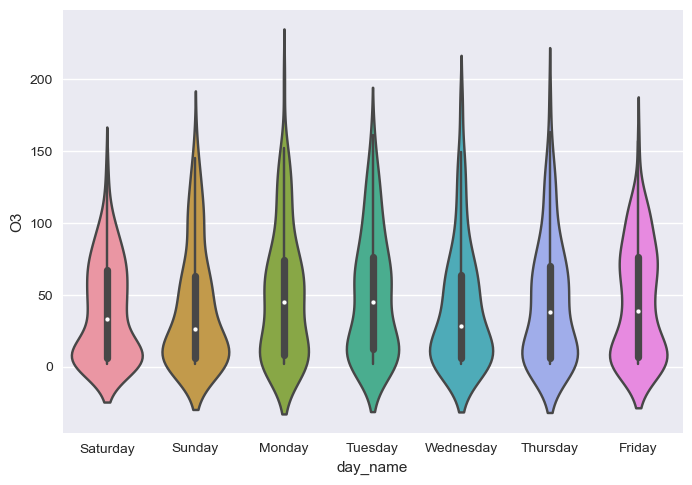

In [64]:

sns.violinplot(data=df_daily, x='day_name', y='O3');

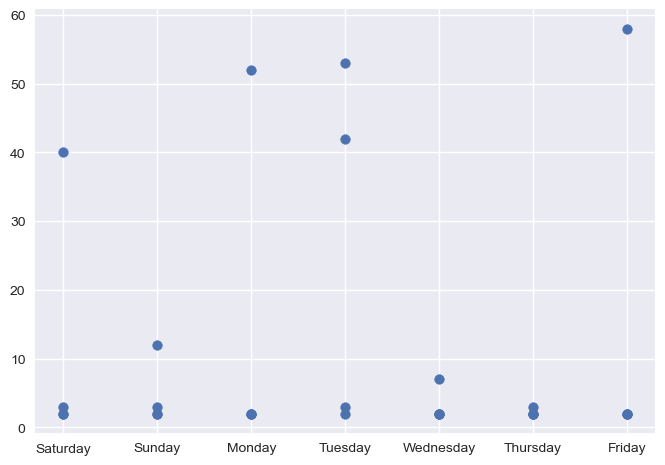

In [67]:
plt.scatter(x=df_daily[0:28]['day_name'], y=df_daily[0:28]['O3']);